set cuda id

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


Install dependencies for computing metrics and plots:

In [2]:
#!pip3 install numpy scipy pandas seaborn matplotlib sklearn

## Basic imports

In [64]:
import jax
import jax.numpy as jnp
import flax
from entmax_jax import sparsemax
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from functools import partial
import json
from entmax_jax.activations import sparsemax, entmax15
from sklearn.metrics import roc_auc_score, average_precision_score

from meta_expl.explainers import load_explainer
from meta_expl.models import load_model
from meta_expl.data.mlqe import dataloader

from evaluate_explanations import evaluate_word_level, evaluate_sentence_level, aggregate_pieces

In [6]:
# plot utils
def unroll(list_of_lists):
    return [e for ell in list_of_lists for e in ell]

def detokenize(pieces):
    return ''.join(pieces).replace('▁', ' ').replace('</s>', ' </s>')

def colorize_twoway(words, color_array, label='GOLD', max_width_shown=1800):
    template_pos = '<span class="barcode"; style="color: black; background-color: rgba(0, 255, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    template_neg = '<span class="barcode"; style="color: black; background-color: rgba(255, 0, 0, {}); display:inline-block; font-size:12px;">&nbsp {} &nbsp</span>'
    colored_string = ''
    f = lambda w: w.replace('<', 'ᐸ').replace('>', 'ᐳ')
    for word, color in zip(words, color_array / color_array.abs().max()):
        if color > 0:
            colored_string += template_pos.format(color, f(word))
        else:
            colored_string += template_neg.format(-color, f(word))
    html_text = '<div style="100%">{}:&nbsp;&nbsp; {}</div>'.format(label, colored_string)
    display(HTML(html_text))

In [7]:
# data utils
def read_data(lp, split='dev'):
    def tags_to_ints(line):
        return list(map(int, line.strip().replace('OK', '0').replace('BAD', '1').split()))
    data = {
        'original': [line.strip() for line in open('data/{}/{}.src'.format(lp, split), 'r')],
        'translation': [line.strip() for line in open('data/{}/{}.mt'.format(lp, split), 'r')],
        'da': [float(line.strip()) for line in open('data/{}/{}.da'.format(lp, split), 'r')],
        'src_tags': [tags_to_ints(line) for line in open('data/{}/{}.src-tags'.format(lp, split), 'r')],
        'mt_tags': [tags_to_ints(line) for line in open('data/{}/{}.tgt-tags'.format(lp, split), 'r')]
    }
    z = np.array(data['da'])
    data['z_mean'] = (z - z.mean()) / z.std()
    data = [dict(zip(data.keys(), v)) for v in list(zip(*data.values()))]
    return data

## Define args and load stuff

In [8]:
# arguments
arch = 'xlm-roberta-base'
arch_mtl = 'xlm-r'
setup = 'no_teacher'  # "no_teacher", "static_teacher", "learnable_teacher"
lp = 'ro-en'
max_len = 256
batch_size = 16
seed = 1
sep_token = "</s>" if 'xlm' in arch else "[SEP]"
num_classes = 1
task_type = "regression"
teacher_dir = 'data/mlqe-xlmr-explainer/teacher_dir'
explainer_dir = 'data/mlqe-xlmr-explainer/teacher_expl_dir'

In [9]:
# create dummy inputs for model instantiation
input_ids = jnp.ones((batch_size, max_len), jnp.int32)
dummy_inputs = {
    "input_ids": input_ids,
    "attention_mask": jnp.ones_like(input_ids),
    "token_type_ids": jnp.arange(jnp.atleast_2d(input_ids).shape[-1]),
    "position_ids": jnp.ones_like(input_ids),
}
dummy_inputs['input_ids'].shape

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


(16, 256)

### load data

In [10]:
# load data
dataloader = partial(dataloader, sep_token=sep_token)
train_data = read_data(lp, "train")
valid_data = read_data(lp, "dev")

### load tokenizer

In [11]:
from transformers import XLMRobertaTokenizerFast
tokenizer = XLMRobertaTokenizerFast.from_pretrained(arch)
cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

### load model and explainer

In [12]:
teacher, teacher_params, dummy_state = load_model(teacher_dir, batch_size, max_len)
teacher_explainer, teacher_explainer_params = load_explainer(explainer_dir, dummy_inputs, state=dummy_state)

## Get explanations

In [103]:
def get_explanations(data, top_layer_head=False):
    all_tokens = []
    all_masks = []
    all_explanations = []
    all_outputs = []
    c = 1
    for x, y in dataloader(data, tokenizer, batch_size=batch_size, max_len=max_len, shuffle=False):
        print('{} of {}'.format(c, len(data) // batch_size + 1), end='\r')
        c += 1
        
        # get teacher output
        y_teacher, teacher_attn = teacher.apply(teacher_params, **x, deterministic=True)
        if task_type == "classification":
            y_teacher = jnp.argmax(y_teacher, axis=-1)
        
        # get explanation from the teacher explainer
        teacher_expl, _ = teacher_explainer.apply(teacher_explainer_params, x, teacher_attn)
        
        if top_layer_head:
            # batch x layers x heads x seqlen x seqlen
            all_attentions = jnp.stack(teacher_attn['attentions']).transpose([1, 0, 2, 3, 4])
            num_layers = all_attentions.shape[1] 
            num_heads = all_attentions.shape[2]

            # get the attention from the teacher associated with the top head coeff
            head_coeffs = sparsemax(teacher_explainer_params['params']['head_coeffs'])
            top_joint_id = jnp.argmax(head_coeffs).item()
            top_layer_id = top_joint_id // num_heads
            top_head_id = top_joint_id % num_heads
            teacher_expl = all_attentions[:, top_layer_id, top_head_id]
        
        if False:
            # get all attentions from the teacher associated with nonzero head coeff
            head_coeffs = head_coeffs.reshape(num_layers, num_heads)
            nonzero_rows, nonzero_cols = head_coeffs.nonzero()
            num_nonzero = len(nonzero_rows)
            original_expls = jnp.stack([
                all_attentions[:, r, c] for r, c in zip(nonzero_rows.tolist(), nonzero_cols.tolist())
            ]).transpose([1, 0, 2, 3])  # batch, num_nonzero, seqlen, seqlen

        # convert everything to lists
        batch_ids = x['input_ids'].tolist()
        batch_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in batch_ids]
        batch_masks = [[tk.startswith('▁') for tk in tokens] for tokens in batch_tokens]
        batch_expls = teacher_expl.tolist()
        
        # filter out pad
        batch_valid_len = x['attention_mask'].sum(-1).tolist()
        for i in range(len(batch_valid_len)):
            n = batch_valid_len[i]
            batch_ids[i] = batch_ids[i][:n]
            batch_tokens[i] = batch_tokens[i][:n]
            batch_masks[i] = batch_masks[i][:n]
            batch_expls[i] = batch_expls[i][:n]
        
        all_tokens.extend(batch_tokens)
        all_masks.extend(batch_masks)
        all_explanations.extend(batch_expls)
        all_outputs.extend(y_teacher.tolist())

    return all_tokens, all_masks, all_explanations, all_outputs

In [17]:
valid_tokens, valid_masks, valid_explanations, valid_outputs = get_explanations(valid_data)
list(map(len, [valid_tokens, valid_masks, valid_explanations, valid_outputs]))

### Aggregate scores for word pieces in SRC and MT independently

In [81]:
import torch
from utils import aggregate_pieces

def get_src_and_mt_explanations(all_tokens, all_fp_masks, all_explanations, reduction):
    src_expls = []
    mt_expls = []
    src_pieces = []
    mt_pieces = []
    for tokens, expl, fp_mask in zip(all_tokens, all_explanations, all_fp_masks):
        # split data into src and mt (assuming "<s> src </s> mt </s>" format without CLS for mt) 
        src_len = tokens.index(tokenizer.sep_token) + 1
        src_tokens, mt_tokens = tokens[:src_len], tokens[src_len:]
        src_expl, mt_expl = expl[:src_len], expl[src_len:]
        src_fp_mask, mt_fp_mask = fp_mask[:src_len], fp_mask[src_len:]
        
        # aggregate word pieces scores (use my old good torch function)
        agg_src_expl = aggregate_pieces(torch.tensor(src_expl), torch.tensor(src_fp_mask), reduction)
        agg_mt_expl = aggregate_pieces(torch.tensor(mt_expl), torch.tensor(mt_fp_mask), reduction)
        
        # remove <s> and </s> from src
        agg_src_expl = agg_src_expl.tolist()[1:-1]
        # remove </s> from mt
        agg_mt_expl = agg_mt_expl.tolist()[:-1]
        
        src_pieces.append(src_tokens)
        mt_pieces.append(mt_tokens)
        src_expls.append(agg_src_expl)
        mt_expls.append(agg_mt_expl)
    return src_expls, mt_expls, src_pieces, mt_pieces

In [92]:
reduction = 'sum'
src_expls, mt_expls, src_pieces, mt_pieces = get_src_and_mt_explanations(
    valid_tokens, valid_masks, valid_explanations, reduction=reduction
)

## Evaluating explanations by comparing explanations with word-level QE tags

In [93]:
# simulating predictions
gold_src_tokens = [inp['original'].split() for inp in valid_data]
gold_mt_tokens = [inp['translation'].split() for inp in valid_data]
gold_expls_src = [inp['src_tags'] for inp in valid_data]
gold_expls_mt = [inp['mt_tags'] for inp in valid_data]
gold_scores = [inp['z_mean'] for inp in valid_data]

pred_expls_src = src_expls
pred_expls_mt = mt_expls
pred_scores = unroll(valid_outputs)

In [84]:
_ = evaluate_sentence_level(gold_scores, pred_scores)

Pearson: 0.7901
Spearman: 0.7382
MAE: 0.5354
RMSE: 0.6634


In [95]:
_ = evaluate_word_level(gold_expls_src, pred_expls_src)

AUC score: 0.6809
AP score: 0.5430
Recall at top-K: 0.4113


In [96]:
_ = evaluate_word_level(gold_expls_mt, pred_expls_mt)

AUC score: 0.6689
AP score: 0.5506
Recall at top-K: 0.4207


## Visualizing explanations

In [56]:
def show_explanation(tokens, tags, explanation):
    import torch
    colorize_twoway(tokens.split(), torch.tensor(tags), label='gold')
    colorize_twoway(tokens.split(), torch.tensor(explanation), label='pred')

In [94]:
idx = 2
print('SRC:')
print('----')
show_explanation(valid_data[idx]['original'], gold_expls_src[idx], pred_expls_src[idx])
print('MT:')
print('----')
show_explanation(valid_data[idx]['translation'], gold_expls_mt[idx], pred_expls_mt[idx])

SRC:
----


MT:
----


## Plotting the distribution of predictions and AUC scores

In [71]:
# define options for seaborn
custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.color': '.85',
    'grid.linestyle': ':'
}
_ = sns.set_theme(style='whitegrid', rc=custom_params),

def plot_da_vs_expl_metric(metric_fn, das, e_golds, e_preds):
    x = []
    y = []
    for da, gold, pred in zip(das, e_golds, e_preds):
        if sum(gold) == 0 or sum(gold) == len(gold):
            continue
        y.append(metric_fn(gold, pred))
        x.append(da)
    x = np.array(x)
    y = np.array(y)
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.histplot(x=x, y=y, ax=axs[0])
    axs[0].set_xlabel('da')
    axs[0].set_ylabel(str(metric_fn).split()[1])
    sns.histplot(x, bins=20, ax=axs[1])
    axs[1].set_xlabel('da')
    sns.histplot(y, bins=20, ax=axs[2])
    axs[2].set_xlabel(str(metric_fn).split()[1])

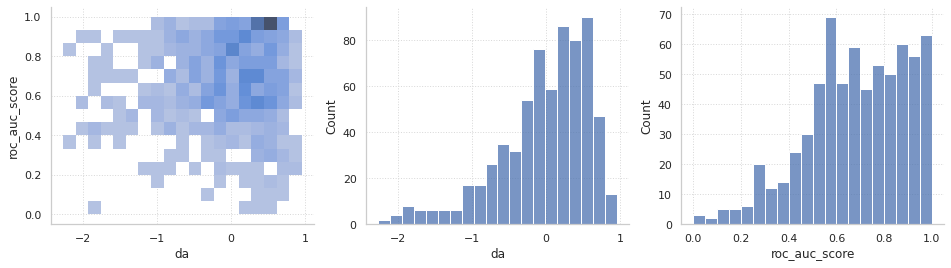

In [75]:
# plot predicted DA vs AUC for src and mt
plot_da_vs_expl_metric(roc_auc_score, pred_scores, gold_expls_src, pred_expls_src)

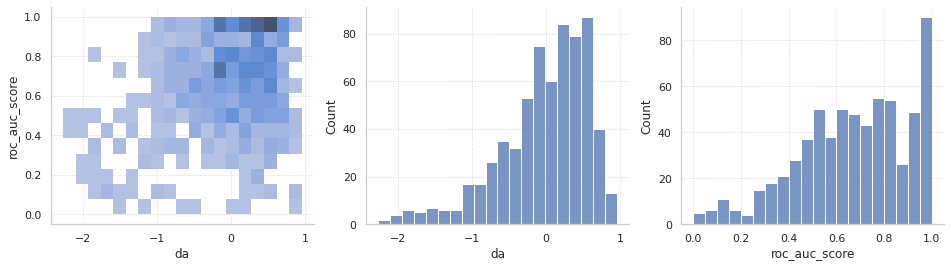

In [76]:
plot_da_vs_expl_metric(roc_auc_score, pred_scores, gold_expls_mt, pred_expls_mt)

## Plotting attention map

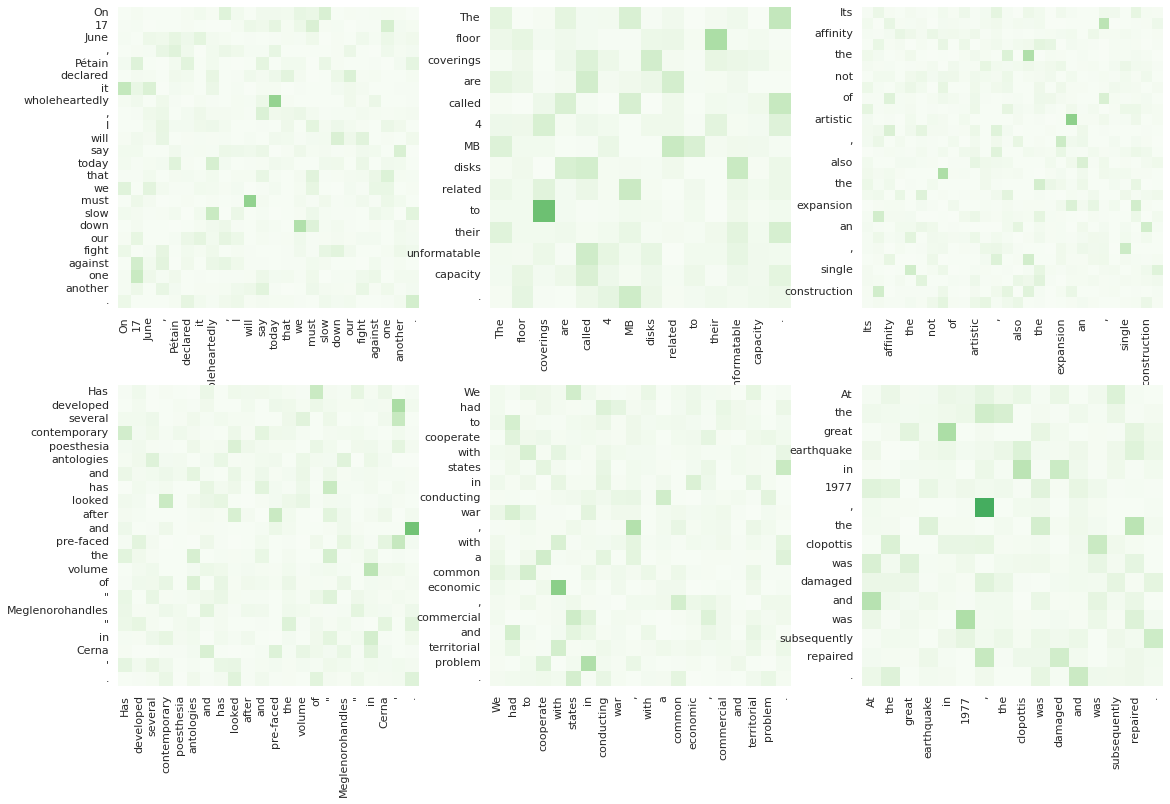

In [63]:
# dummy code, just to exemplify
fig, axs = plt.subplots(2, 3, figsize=(16, 11))
fig.tight_layout(pad=3)
for i in range(6):
    ax = axs[i//3, i%3]
    tokens = valid_data[i]['translation'].split()
    n = len(tokens)
    softmax = lambda x: np.exp(x) / np.exp(x).sum()
    A = np.stack([softmax(np.random.randn(n)) for _ in range(n)])
    df = pd.DataFrame(A, columns=tokens, index=tokens)
    sns.heatmap(df, vmax=1, cmap="Greens", square=True, cbar=False, ax=ax)